*Reference: https://medium.com/swlh/5-tips-for-working-with-time-series-in-python-d889109e676d*

# Modeling Techniques to minimize effect of White Noise

* Importing Libraries

In [1]:
import yfinance as yf
import datetime  # For datetime objects
import backtrader as bt
import pandas as pd
import numpy as np
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt
from pykalman import KalmanFilter
from hurst import compute_Hc
import csv
import warnings
warnings.filterwarnings('ignore')

* Dowloading data

In [2]:
data_yf = bt.feeds.PandasData(dataname=yf.download('SPY', '2019-01-01', '2022-10-11'))

[*********************100%***********************]  1 of 1 completed


In [3]:
SPY = yf.download('SPY', '2019-01-01', '2022-10-03') # Daily chart data

[*********************100%***********************]  1 of 1 completed


In [4]:
Hour_data = pd.read_excel(r'60 DATA.xlsx')# 60 mins chart data
Hour_data.set_index('Date', inplace=True)

* Dataframe to series

In [5]:
SPY_series = SPY['Close'].squeeze() # Daily chart
Hour_data_series = Hour_data['Close'].squeeze() # Hour chart

* First we use Fast fourier transform denoiser to attempt to reduce white noise

*Reference: https://gist.github.com/Xylambda/b8f38dce74dd3d54ff906eebfe560ac0#file-denoiser-py*

In [6]:
def fft_denoiser(x, n_components, to_real=True):
    """Fast fourier transform denoiser.
    
    Denoises data using the fast fourier transform.
    
    Parameters
    ----------
    x : numpy.array
        The data to denoise.
    n_components : int
        The value above which the coefficients will be kept.
    to_real : bool, optional, default: True
        Whether to remove the complex part (True) or not (False)
        
    Returns
    -------
    clean_data : numpy.array
        The denoised data.
        
    References
    ----------
    .. [1] Steve Brunton - Denoising Data with FFT[Python]
       https://www.youtube.com/watch?v=s2K1JfNR7Sc&ab_channel=SteveBrunton
    
    """
    n = len(x)
    
    # compute the fft
    fft = np.fft.fft(x, n)
    
    # compute power spectrum density
    # squared magnitud of each fft coefficient
    PSD = fft * np.conj(fft) / n
    
    # keep high frequencies
    _mask = PSD > n_components
    fft = _mask * fft
    
    # inverse fourier transform
    clean_data = np.fft.ifft(fft)
    
    if to_real:
        clean_data = clean_data.real
    
    return clean_data

* Transferring the data to array

For the n_components we choose 2400 as at this number we got the highest portfolio return, (find below at the bactrader backtest section), below and above 2400 the return is lower.

Daily Data

In [7]:
SPY_array = SPY_series.to_numpy() # Daily chart data
denoiser_test_1 = fft_denoiser(SPY_array, 2400, to_real=True)

Hour Data

In [8]:
Hour_data_array = Hour_data_series.to_numpy() # Daily chart data
Hour_denoiser_test_1 = fft_denoiser(Hour_data_array, 2400, to_real=True)

* Ploting the filtered results based on daily chart data

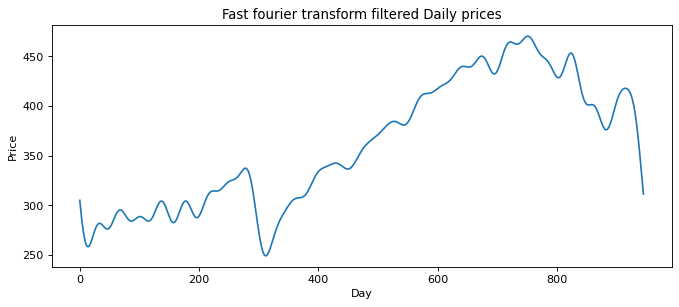

In [9]:
figure(figsize=(10, 4), dpi=80)
plt.plot(denoiser_test_1)
plt.title('Fast fourier transform filtered Daily prices')
plt.xlabel('Day')
plt.ylabel('Price')
plt.show()

* Ploting the filtered results based on daily chart data

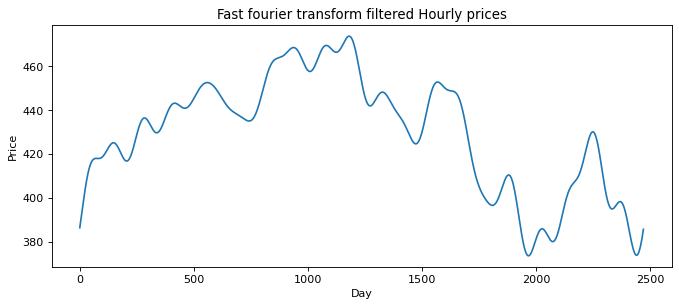

In [10]:
figure(figsize=(10, 4), dpi=80)
plt.plot(Hour_denoiser_test_1)
plt.title('Fast fourier transform filtered Hourly prices')
plt.xlabel('Day')
plt.ylabel('Price')
plt.show()

* Compute and plot the Hurst Exponent based on Daily data

Hurst Exponent based on daily Original price data

In [11]:
SPY['H']=0
# Computing rolling hurst values
for i in range(101,len(SPY)):
    SPY.H.iloc[i]=compute_Hc(SPY.Close.iloc[i-101:i-1], kind='price')[0]

Hurst Exponent based on FFT filtered Daily price data

In [12]:
SPY_FFT_filtered = pd.Series(denoiser_test_1)
SPY_FFT_filtered.index=SPY.index
SPY_df_FFT = SPY[['Open', 'High', 'Low','Volume']]
SPY_df_FFT['Close'] = SPY_FFT_filtered

In [13]:
SPY_df_FFT['H']=0
# Computing rolling hurst values
for i in range(101,len(SPY)):
    SPY_df_FFT.H.iloc[i]=compute_Hc(SPY_df_FFT.Close.iloc[i-101:i-1], kind='price')[0]

* Ploting the filtered results and the original data

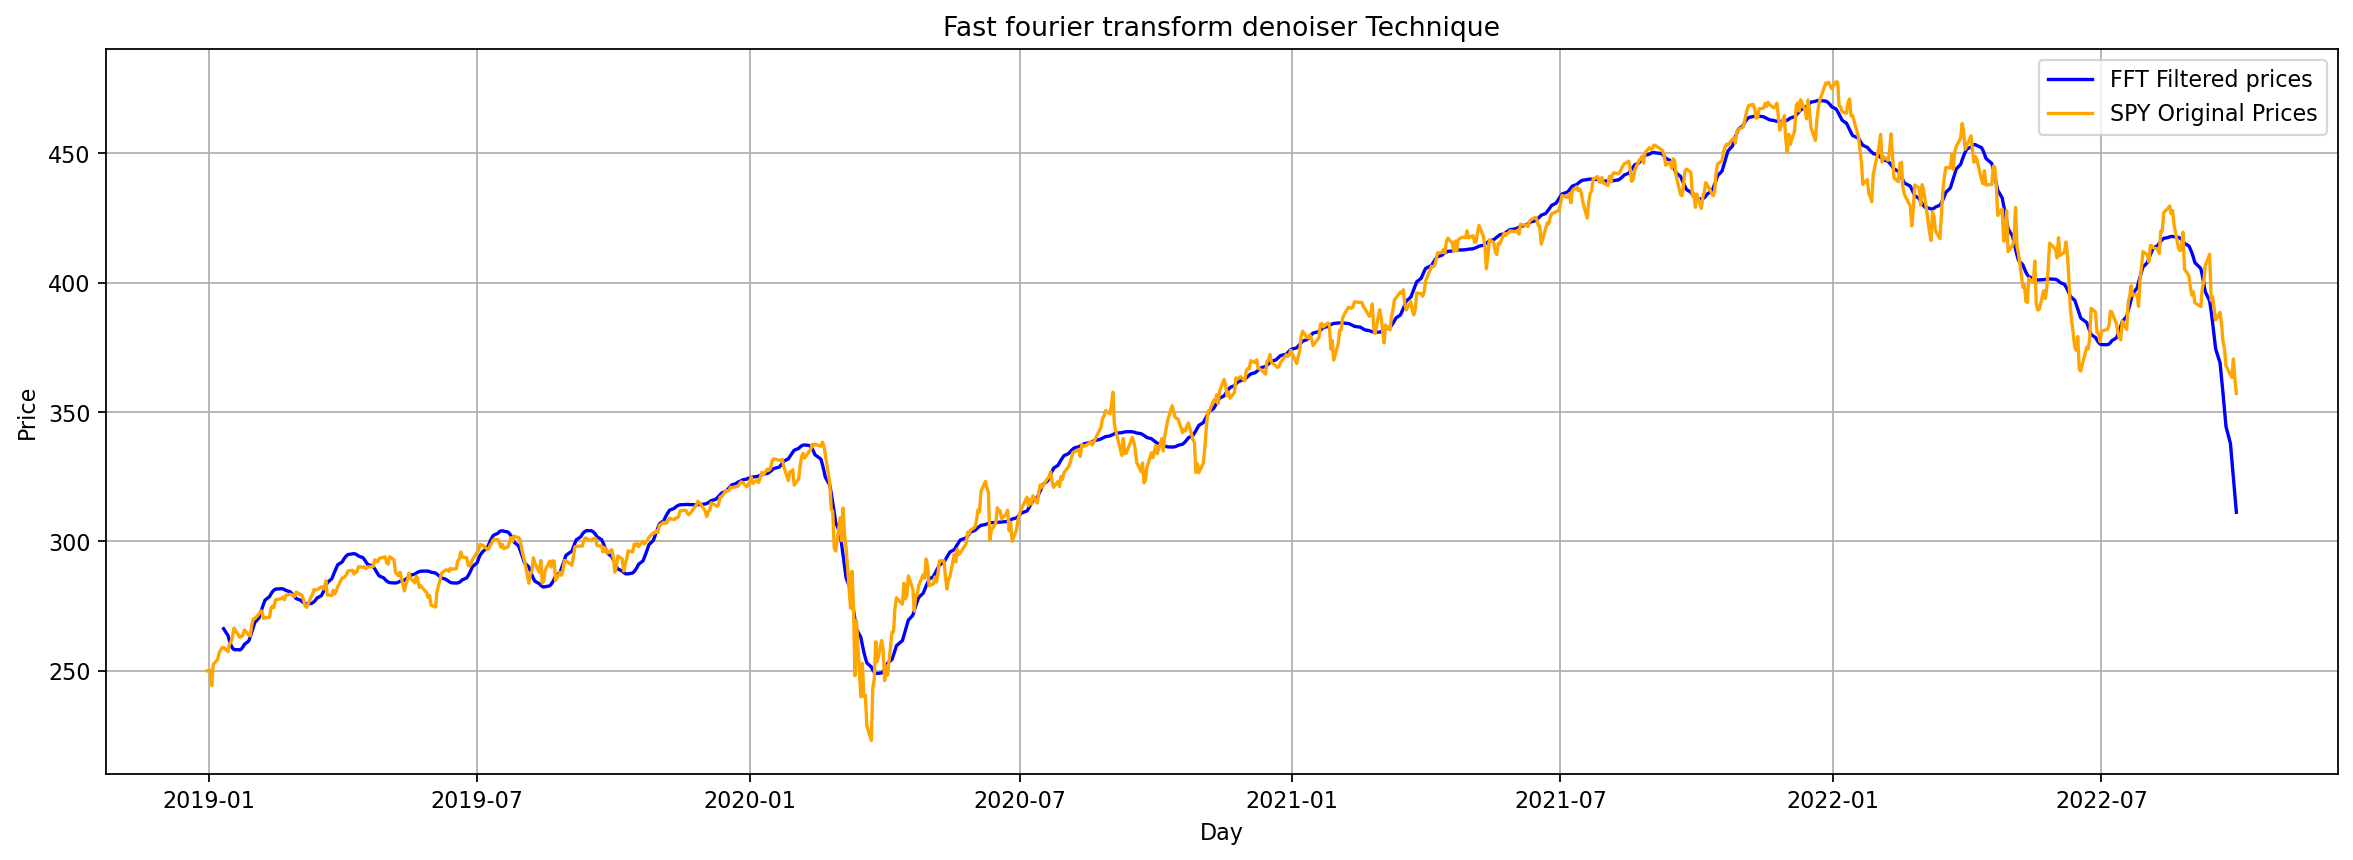

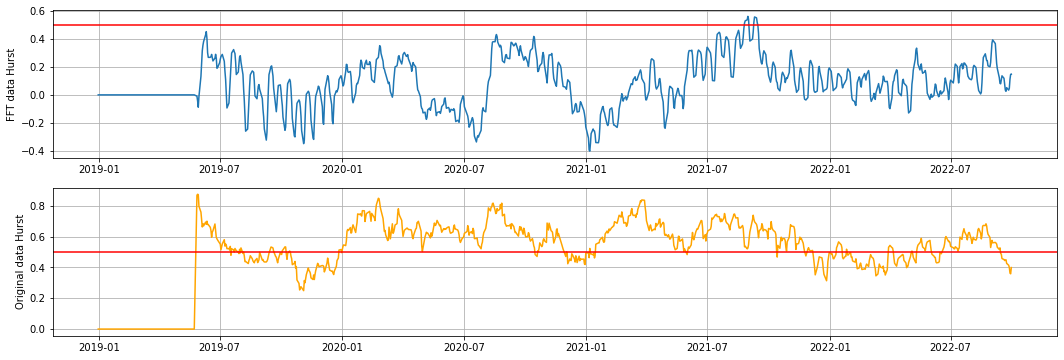

In [14]:
fig = plt.figure(figsize=(18, 6), dpi=160)
ax = fig.add_subplot(1, 1,1)
ax.plot(SPY_FFT_filtered[8:], color='blue')
ax.plot(SPY_series, color='orange')
plt.grid()
plt.title('Fast fourier transform denoiser Technique')
plt.legend(['FFT Filtered prices', 'SPY Original Prices'])
plt.xlabel('Day')
plt.ylabel('Price')
plt.figure(figsize=(18,6))
plt.subplot(211)
plt.plot(SPY_df_FFT.H)
#plt.axhline(0.35,color='g')
plt.axhline(0.5,color='r')
plt.ylabel('FFT data Hurst')
plt.grid()
plt.subplot(212)
plt.plot(SPY.H, color='orange')
#plt.axhline(0.35,color='g')
plt.axhline(0.5,color='r')
plt.ylabel('Original data Hurst')
plt.grid()
plt.show()

* Compute and plot the Hurst Exponent based on 1 hour data

In [15]:
#Converting array to Series
Hour_denoiser_test_1_series = pd.Series(Hour_denoiser_test_1.flatten(), index=Hour_data.index)

Hurst Exponent based on 1 hour Original price data

In [16]:
Hour_data['H']=0
# Computing rolling hurst values
for i in range(101,len(Hour_data)):
    Hour_data.H.iloc[i]=compute_Hc(Hour_data.Close.iloc[i-101:i-1], kind='price')[0]

Hurst Exponent based on 1 hour FFT filtered price data

In [17]:
#H_FFT_filtered = pd.Series(Hour_data)
H_FFT_filtered = Hour_data[['Open', 'High', 'Low','Volume']]
H_FFT_filtered.index=Hour_data.index
H_FFT_filtered['Close'] = Hour_denoiser_test_1_series

In [18]:
H_FFT_filtered['H']=0
# Computing rolling hurst values
for i in range(101,len(H_FFT_filtered)):
    H_FFT_filtered.H.iloc[i]=compute_Hc(H_FFT_filtered.Close.iloc[i-101:i-1], kind='price')[0]

* Ploting the filtered results and the original data

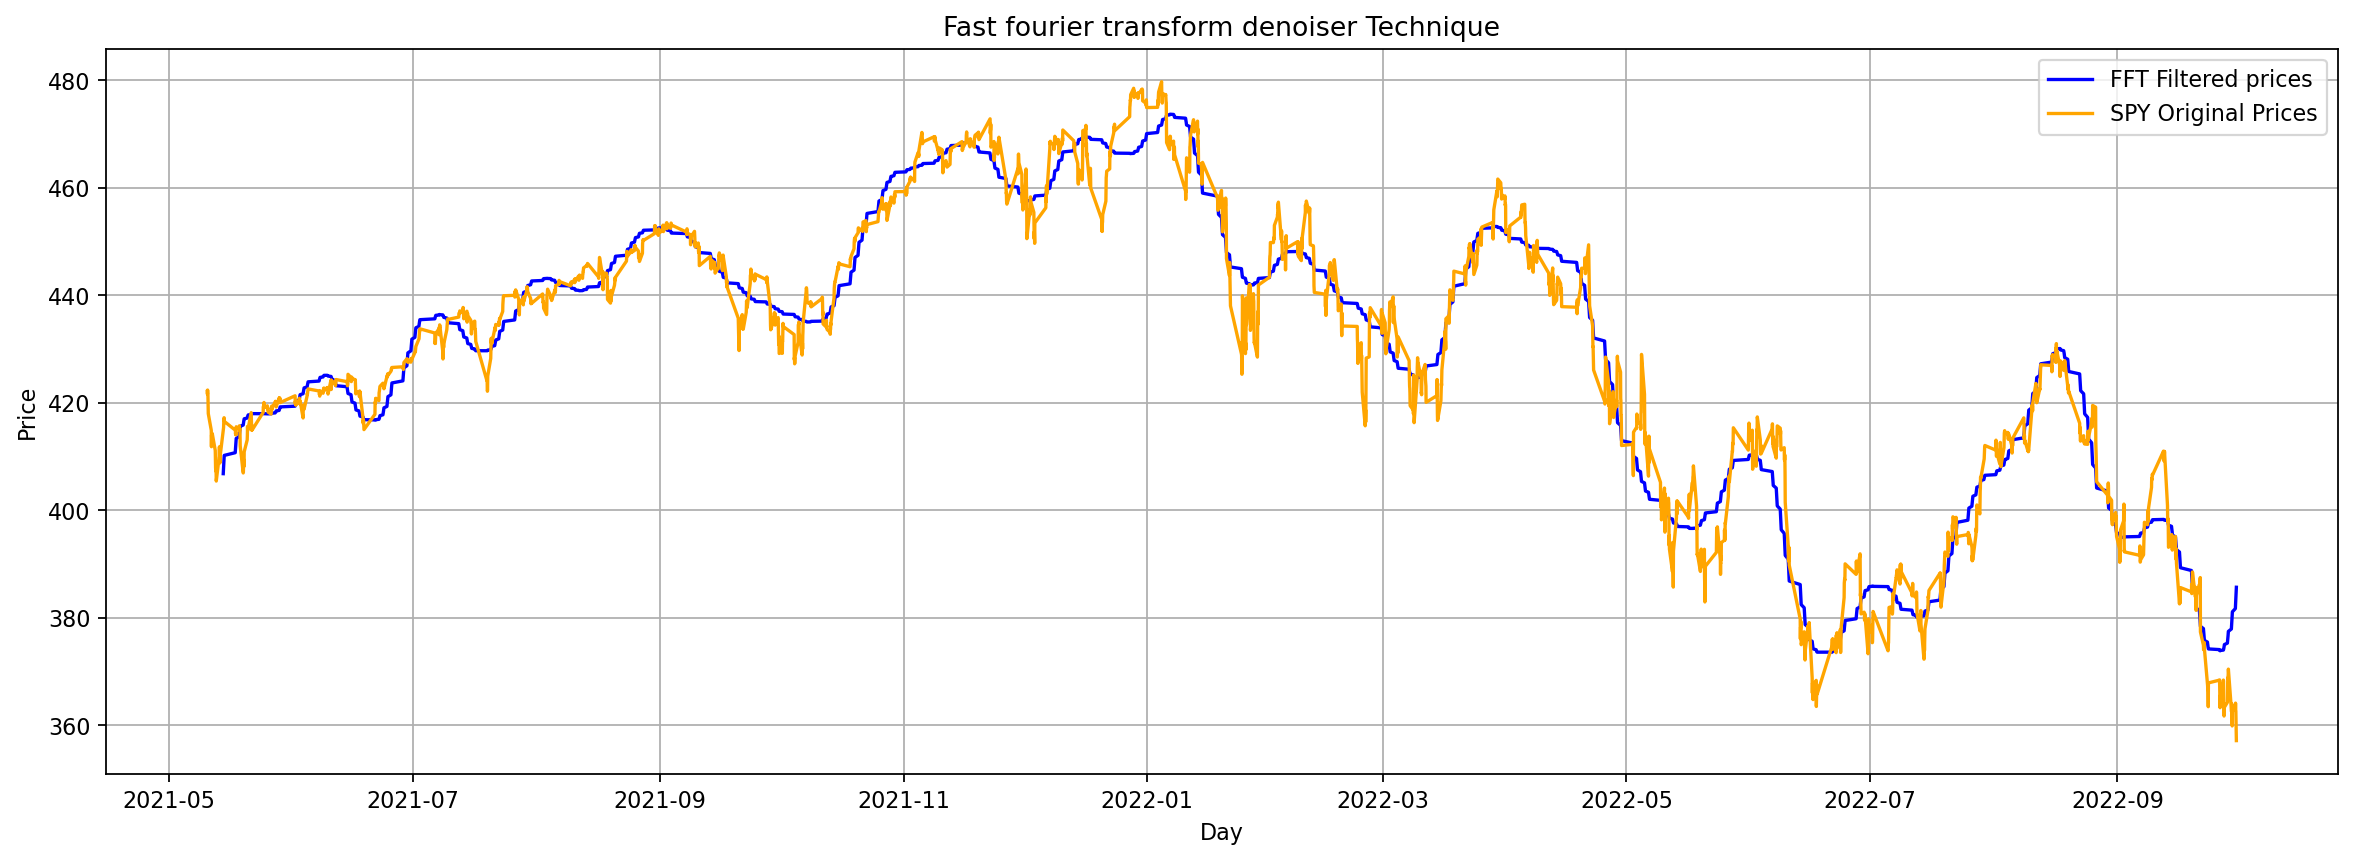

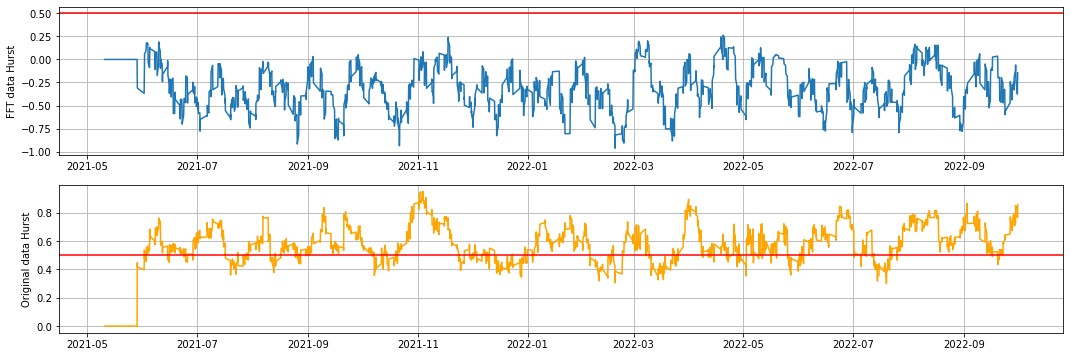

In [19]:
fig = plt.figure(figsize=(18, 6), dpi=160)
ax = fig.add_subplot(1, 1,1)
ax.plot(Hour_denoiser_test_1_series[28:], color='blue')
ax.plot(Hour_data_series, color='orange')
plt.grid()
plt.title('Fast fourier transform denoiser Technique')
plt.legend(['FFT Filtered prices', 'SPY Original Prices'])
plt.xlabel('Day')
plt.ylabel('Price')
plt.figure(figsize=(18,6))
plt.subplot(211)
plt.plot(H_FFT_filtered.H)
#plt.axhline(0.35,color='g')
plt.axhline(0.5,color='r')
plt.ylabel('FFT data Hurst')
plt.grid()
plt.subplot(212)
plt.plot(Hour_data.H, color='orange')
#plt.axhline(0.35,color='g')
plt.axhline(0.5,color='r')
plt.ylabel('Original data Hurst')
plt.grid()
plt.show()

* **Secondly, we attempt to use KalmanFilter to attempt to reduce white noise**

*Reference: https://github.com/quantopian/research_public/blob/master/notebooks/lectures/Kalman_Filters/notebook.ipynb*

In [20]:
from pykalman import KalmanFilter

* Construct a Kalman filter

*The mean is the model's guess for the mean of the distribution from which measurements are drawn, so our prediction of the next value is simply equal to our estimate of the mean. We assume that the observations have variance 1 around the rolling mean, for lack of a better estimate. Our initial guess for the mean is 0, but the filter quickly realizes that that is incorrect and adjusts.*

In [21]:
kf = KalmanFilter(transition_matrices = [1],
                  observation_matrices = [1],
                  initial_state_mean = 0,
                  initial_state_covariance = 1,
                  observation_covariance=1,
                  transition_covariance=.01)

* Use the observed values of the price to get Kalman filtered prices based on Daily data

In [22]:
state_means, _ = kf.filter(SPY_series.values) # Daily data
state_means = pd.Series(state_means.flatten(), index=SPY_series.index)

* Use the observed values of the price to get Kalman filtered prices based on Hour data

In [23]:
hour_state_means, _ = kf.filter(Hour_data_series.values) # Daily data
hour_state_means = pd.Series(hour_state_means.flatten(), index=Hour_data_series.index)

Hurst Exponent based on Kalman filtered Daily price data

In [24]:
D_Kalman_df = SPY[['Open', 'High', 'Low', 'Volume']]
D_Kalman_df['Close'] = state_means

In [25]:
D_Kalman_df['H']=0
for i in range(101,len(D_Kalman_df)):
    D_Kalman_df.H.iloc[i]=compute_Hc(D_Kalman_df.Close.iloc[i-101:i-1], kind='price')[0]

* Ploting the filtered results and the original data based on Daily chart

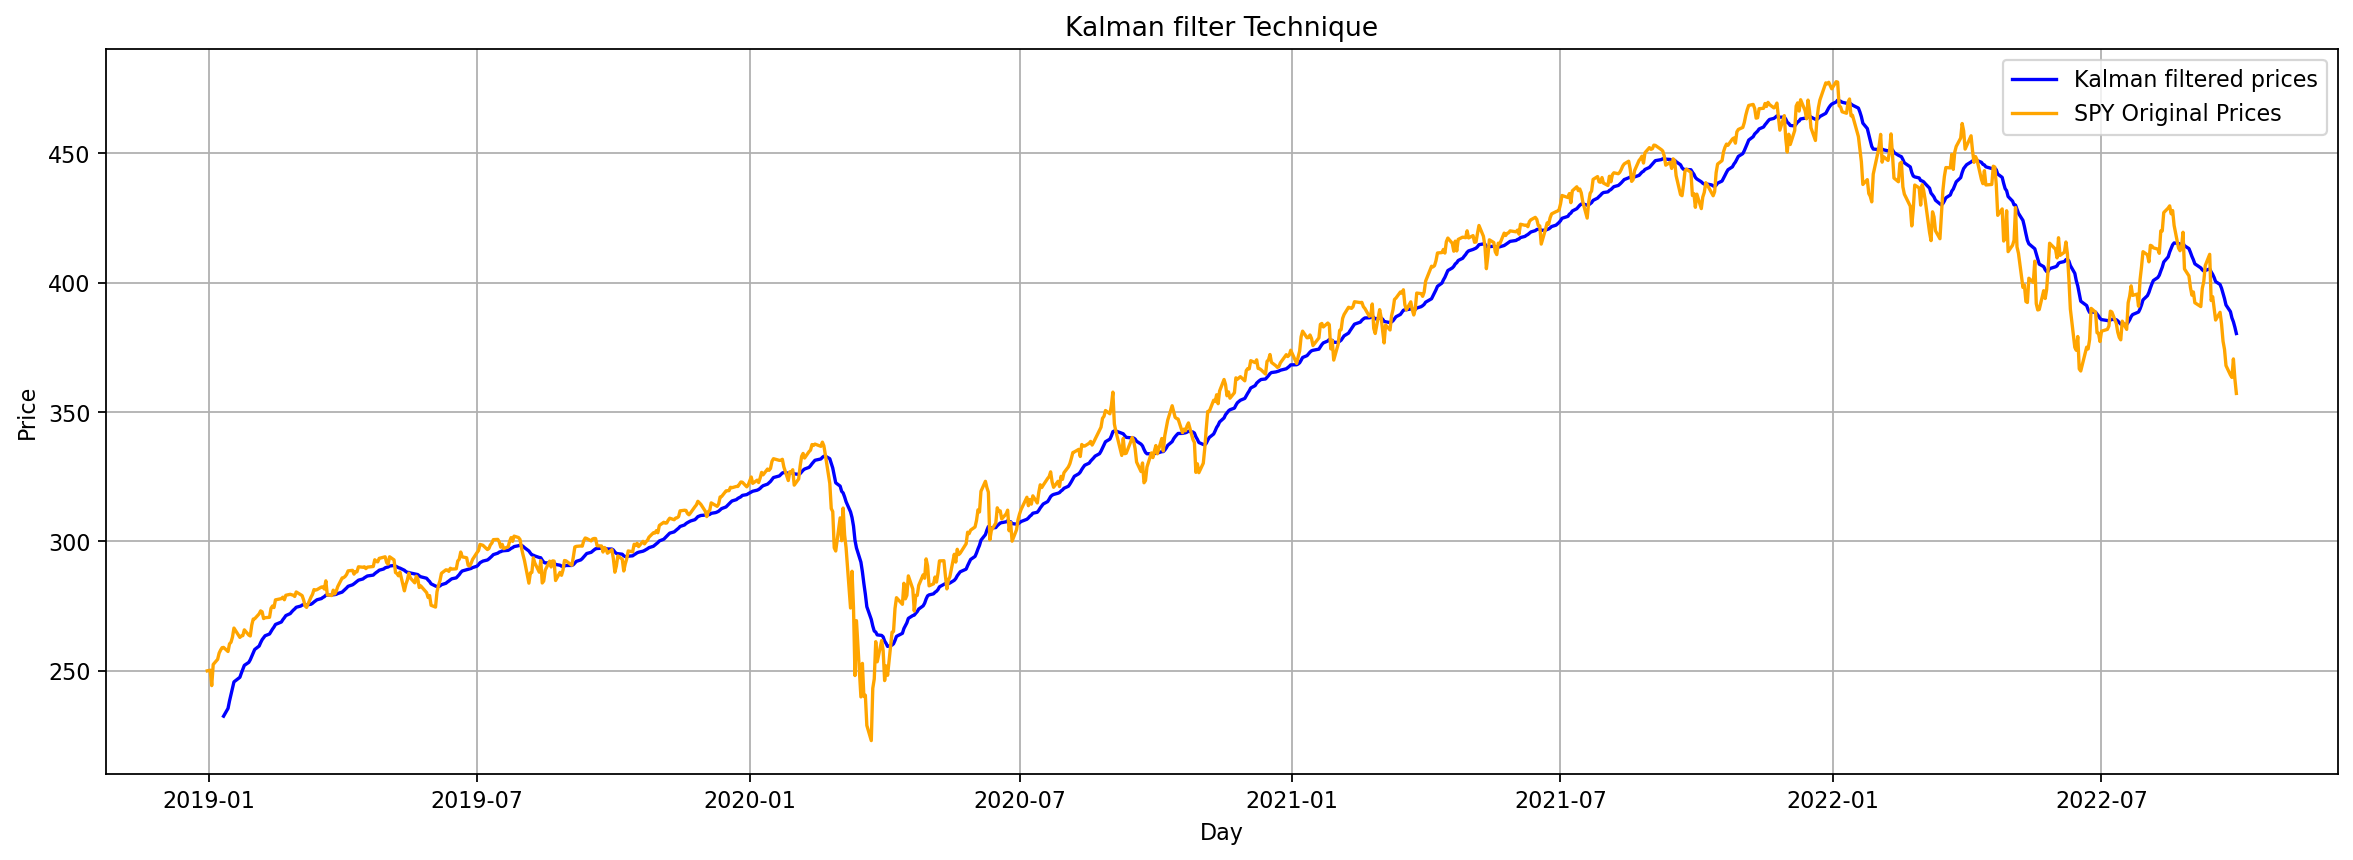

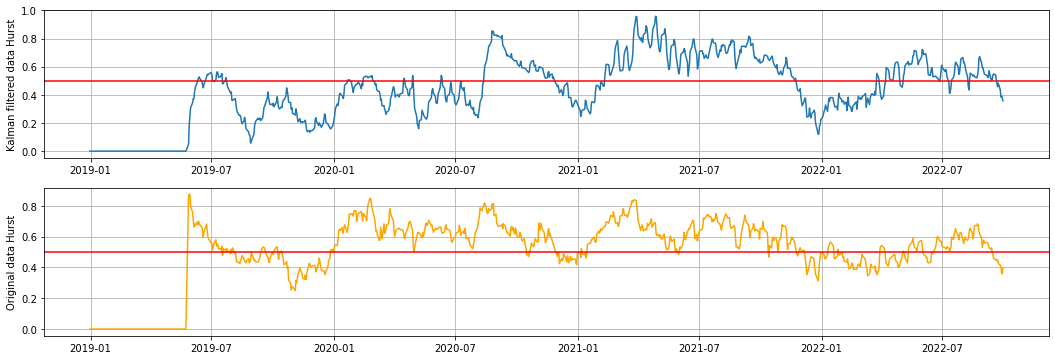

In [26]:
fig = plt.figure(figsize=(18, 6), dpi=160)
ax = fig.add_subplot(1, 1,1)
ax.plot(state_means[8:], color='blue')
ax.plot(SPY_series, color='orange')
plt.grid()
plt.title('Kalman filter Technique')
plt.legend(['Kalman filtered prices', 'SPY Original Prices'])
plt.xlabel('Day')
plt.ylabel('Price')
plt.figure(figsize=(18,6))
plt.subplot(211)
plt.plot(D_Kalman_df.H)
#plt.axhline(0.35,color='g')
plt.axhline(0.5,color='r')
plt.ylabel('Kalman filtered data Hurst')
plt.grid()
plt.subplot(212)
plt.plot(SPY.H, color='orange')
#plt.axhline(0.35,color='g',)
plt.axhline(0.5,color='r',)
plt.ylabel('Original data Hurst')
plt.grid()
plt.show()

Hurst Exponent based on Kalman filtered Hour price data

In [27]:
H_Kalman_df = Hour_data[['Open', 'High', 'Low', 'Volume']]
H_Kalman_df['Close'] = hour_state_means

In [28]:
H_Kalman_df['H']=0
for i in range(101,len(H_Kalman_df)):
    H_Kalman_df.H.iloc[i]=compute_Hc(H_Kalman_df.Close.iloc[i-101:i-1], kind='price')[0]

* Ploting the filtered results and the original data based on Hourly chart

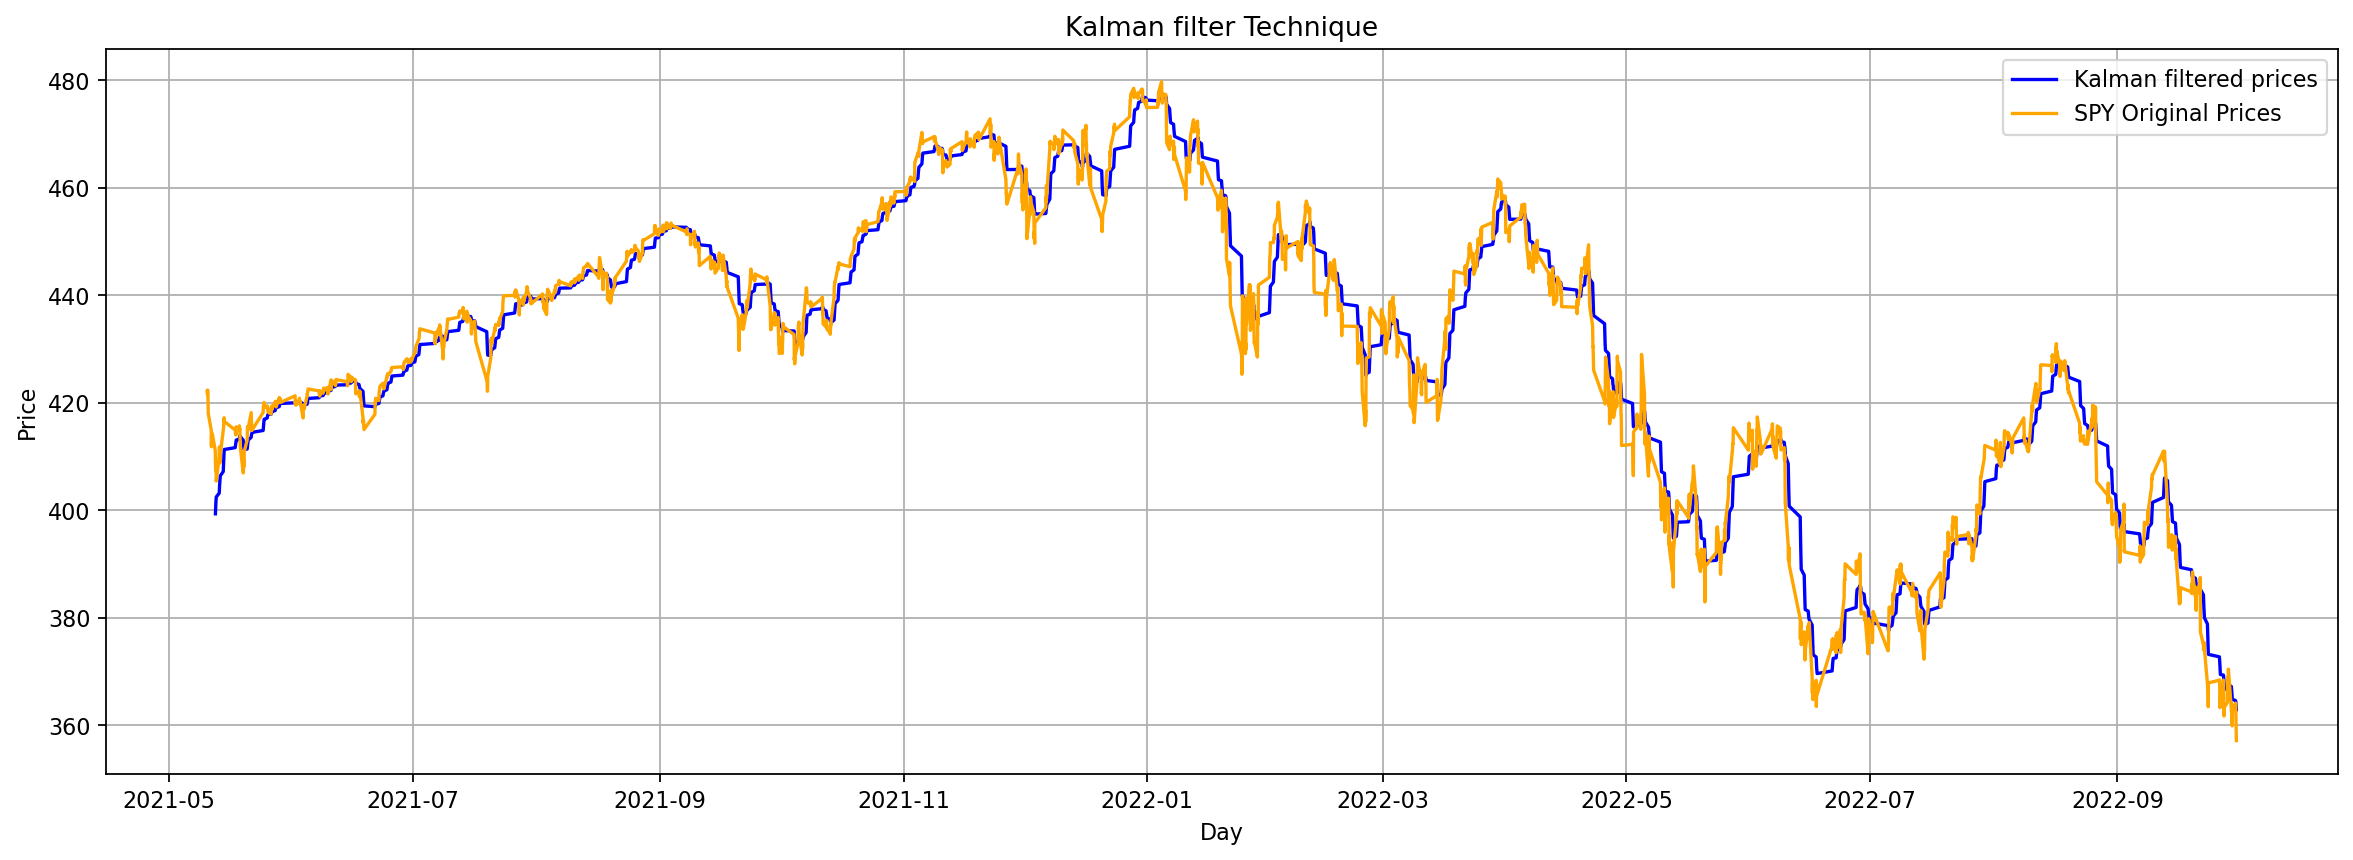

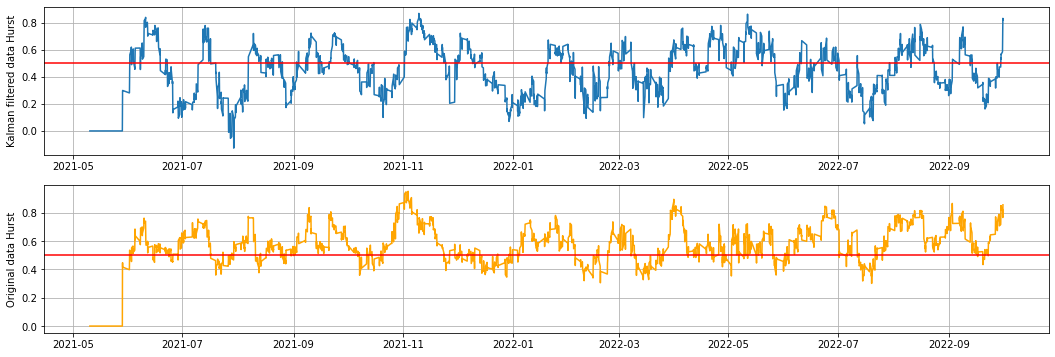

In [29]:
fig = plt.figure(figsize=(18, 6), dpi=160)
ax = fig.add_subplot(1, 1,1)
ax.plot(hour_state_means[15:], color='blue')
ax.plot(Hour_data_series, color='orange')
plt.grid()
plt.title('Kalman filter Technique')
plt.legend(['Kalman filtered prices', 'SPY Original Prices'])
plt.xlabel('Day')
plt.ylabel('Price')
plt.figure(figsize=(18,6))
plt.subplot(211)
plt.plot(H_Kalman_df.H)
#plt.axhline(0.35,color='g')
plt.axhline(0.5,color='r')
plt.ylabel('Kalman filtered data Hurst')
plt.grid()
plt.subplot(212)
plt.plot(Hour_data.H, color='orange')
#plt.axhline(0.35,color='g')
plt.axhline(0.5,color='r')
plt.ylabel('Original data Hurst')
plt.grid()
plt.show()

*The advantage of the Kalman filter is that we don't need to select a window length, so we run less risk of overfitting. We do open ourselves up to overfitting with some of the initialization parameters for the filter, but those are slightly easier to objectively define. There's no free lunch and we can't eliminate overfitting, but a Kalman Filter is more rigorous than a moving average and generally better.*